# [프로젝트] Code Interpreter를 이용한 데이터 분석 및 차트 제너레이터 Agent

랭체인의 Code Interpreter를 이용해, 주어진 파일의 데이터를 분석하는 에이전트를 만들어 보겠습니다.   

사용자의 질의와 파일 경로를 받아, 시각화 아이디어를 구상하고 이를 통해 파이썬 코드를 작성해 실행합니다.

In [1]:
!pip install plotly seaborn langgraph langchain langchain_google_genai langchain_community dotenv --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 11.4

이번 실습에서는 한국어 시각화가 필요합니다.
실제로 활용할 때에는, OS의 환경에 맞게 수정하시면 됩니다.

In [38]:
# Colab/Linux 환경에서 아래 옵션을 실행합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 실행 후 반드시 세션을 다시 시작합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,561 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 125080 files and dire

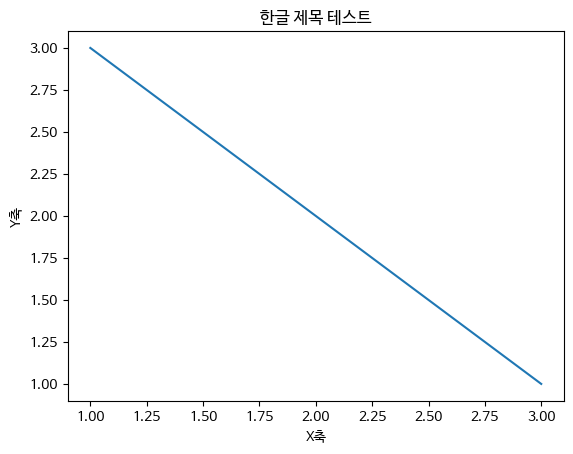

In [1]:
# 한글 출력 테스트 (한글 폰트가 있는 경우)
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
plt.plot([1, 2, 3], [3, 2, 1])
plt.title("한글 제목 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.show()

In [42]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Dict, Any, Optional, Tuple

# 환경 변수 로드
load_dotenv()


os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    temperature=0.2
    # max_tokens

    # thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)


In [28]:
from typing_extensions import TypedDict
from typing import List, Optional, Dict, Any, Union, Annotated, TypedDict, Literal

class State(TypedDict):
    query : str
    first_analysis : str
    planner_request : str
    file_path : str
    code : str
    evaluation : str
    decision : str
    final_insight : list[str]
    img : list[str]
    num_revision : int
    # 리비전의 횟수 제한하기

파일 경로와 질문이 주어지면, 시각화 아이디어를 제공하는 노드를 구성합니다.

In [29]:
from langchain_core.tools import tool
from typing import Annotated
from io import StringIO
import sys
from contextlib import redirect_stdout

# LangChain 최신 버전은 REPL Tool과 호환성 문제가 있어 직접 구현
# LLM이 감독 없이 파이썬 코드를 직접 실행하는 것은 위험합니다. (참고: https://news.hada.io/topic?id=23862)
def python_repl(code: str) -> str:
    code = code.strip().strip('`')
    if code.startswith('python'):
        code = code[6:].strip()

    buffer = StringIO()

    try:
        with redirect_stdout(buffer):
            exec(code, globals())

        output = buffer.getvalue()
        return output if output else "실행 완료"

    except Exception as e:
        return f"Error: {type(e).__name__}: {str(e)}"

In [30]:
from typing import Annotated

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = python_repl(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed the code. \nStdout: {result}"
    return result_str

데이터를 분석하기 전, 기본적인 정보는 필요합니다.

data_prepare_agent를 react agent로 구성합니다.

In [48]:
from langgraph.prebuilt import create_react_agent

from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field
# query와 messages를 저장


# Chart Agent 프롬프트
data_prepare_agent = create_react_agent(llm, [python_repl_tool],
    prompt="""python_repl을 사용해, 주어진 파일을 간단히 분석하세요.

다음의 순서로 실행하세요.
1. 해당 파일을 읽고, 컬럼 이름을 파악하세요.
2. 파악한 결과를 바탕으로, 개략적인 통계 자료를 출력하세요.
주로 다음과 같은 항목이 포함됩니다:
행과 열의 개수
예시 데이터

실패하는 경우, 적절한 인코딩 방식을 활용하여 재시도하세요."""
)

def prepare_data(state:State):
    messages=[HumanMessage(f"파일 경로는 f{state['file_path']} 입니다.")]
    file_path = state['file_path']
    code_result = data_prepare_agent.invoke({'messages':[HumanMessage(f'파일 경로:{file_path}')]})
    first_analysis = code_result['messages'][-1].content
    return {'first_analysis':first_analysis}



/tmp/ipython-input-3544201496.py:10: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  data_prepare_agent = create_react_agent(llm, [python_repl_tool],


In [49]:
from langchain_core.prompts import ChatPromptTemplate


# 시각화 기획자 에이전트
planner_prompt = ChatPromptTemplate(["""
당신은 데이터 시각화 전문가로 사용자가 제공한 데이터와 요청을 분석하여 최적의 시각화 전략을 수립하는 역할을 맡고 있습니다.

## 데이터 정보:
{first_analysis}

## 사용자 쿼리:
{query}

## 당신의 임무:
1. 데이터 파일을 분석하고 구조와 주요 변수를 파악하세요.
2. 사용자 쿼리의 의도를 명확히 파악하세요.
3. 데이터와 쿼리를 바탕으로 가장 적합한 시각화 유형(막대 그래프, 산점도, 히트맵 등)을 결정하세요.
4. 시각화를 위한 상세 계획을 작성하세요.

## 응답 형식:
다음 섹션을 포함한 계획서를 작성해주세요:
1. 데이터 분석: 데이터 구조, 주요 변수, 특징 등을 설명
2. 사용자 의도 분석: 사용자가 무엇을 알고 싶어하는지 분석
3. 시각화 전략: 어떤 시각화가 적합한지와 그 이유
4. 구체적인 요청사항:
   - 차트 유형
   - 사용할 변수
   - 색상 테마 (필요시)
   - 강조할 부분
   - 제목 및 레이블 제안
   - 기타 특별 요청사항

이 계획서는 시각화 개발자가 실제 코드를 작성하는 데 사용될 것입니다.
"""])


def generate_visualization_idea(state:State):
    chain = planner_prompt | llm
    response = chain.invoke(state)
    return {'planner_request':response.content}


In [50]:
developer_prompt = ChatPromptTemplate(["""
당신은 데이터 시각화 개발자로서, 시각화 기획자가 제공한 계획에 따라 Python 코드를 작성하여 데이터를 시각화하는 역할을 맡고 있습니다.

## 데이터 파일 경로:
{file_path}


## 데이터의 일부 정보

{first_analysis}

## 시각화 기획자의 요청사항:
{planner_request}

## 평가자의 추가 요청사항:
{evaluation}

## 당신의 임무:
1. 제공된 데이터 파일을 로드하는 코드를 작성하세요.
2. 시각화 기획자의 요청사항에 따라 적절한 시각화 라이브러리(matplotlib, seaborn, plotly 등)를 사용하여 코드를 작성하세요.
3. 시각화 결과를 생성하고 저장하는 코드를 작성하세요.

작성에서 매우 중요한 규칙은 다음과 같습니다.
한글 데이터가 주로 주어지므로, 아래 코드를 꼭 포함하세요.

plt.rc('font', family='NanumBarunGothic')

매 시각화 결과는 현재 폴더에, 적절한 이름의 .png 파일로 저장하세요."""])
# 디버깅이 잘 안 되면, 실제 코드 스니펫을 추가하는 방법도 좋음


def execute_visualization(state:State):
    chain  = developer_prompt | llm
    response = chain.invoke(state)

    def parse(code):
        if '```' in code:
            code = code.split('```python')[1].split('```')[0]
        return code
    code_to_execute = parse(response.content)
    return {'code':code_to_execute}


In [51]:
evaluator_prompt = ChatPromptTemplate(["""
당신은 데이터 시각화 평가 전문가로서, 생성된 시각화가 사용자의 원래 의도와 요구사항을 얼마나 잘 충족시키는지 평가하는 역할을 맡고 있습니다.

## 원래 사용자 쿼리:
{query}

## 원래 시각화 계획:
{planner_request}

## 개발자가 작성한 코드 및 설명:
{code}

## 당신의 임무:
1. 생성된 시각화가 사용자의 원래 의도와 요구사항을 얼마나 잘 충족시키는지 판단하여, 시각화의 강점과 약점을 분석하세요.
2. 개선이 필요한 부분이 있는지 확인하고, 필요하다면 구체적인 개선 방향을 제시하세요.
3. 시각화 결과물 위주로 평가하세요. 파일 저장이나, 사용자 입력 등은 고려하지 마세요.
4. matplotlib이나, seaborn의 범위로 해결 가능한 피드백만을 제공해야 합니다.

## 응답 형식:
다음 항목을 포함한 평가서를 작성해주세요:
1. 종합 평가: 시각화가 사용자 요구사항을 얼마나 잘 충족시키는지에 대한 종합적인 평가
2. 개선점: 보완이 필요한 부분
3. 개선 제안: 구체적인 개선 방향 및 추가 시각화 제안 (필요시)
4. 최종 결정: 다음 중 하나를 선택
   - COMPLETE: 시각화가 충분히 좋으며 더 이상의 개선이 필요 없음
   - REVISE: 개선이 필요하며 구체적인 수정 사항 제시

평가서는 간략한 개조식으로 작성하세요.
개선이 필요한 경우, 시각화 개발자에게 전달할 구체적인 수정 요청을 포함해주세요.
"""])

class evaluation(BaseModel):
    comment: str = Field(description="시각화에 대한 전체 평가 내용")
    decision: Literal['COMPLETE', 'REVISE'] = Field(description='평가에 대한 최종 결정')

def evaluate_visualization(state:State):

    num_revision = state.get('num_revision',0)

    chain = evaluator_prompt | llm.with_structured_output(evaluation)
    response = chain.invoke(state)

    num_revision += 1 # 리비전 횟수 증가

    return {'evaluation':response.comment,
            'decision':response.decision,
            'num_revision':num_revision}

In [52]:
import os
import PIL.Image
import base64
import contextlib
import io

finalize_prompt = ChatPromptTemplate([
    ('system',"""
데이터 파일에 대한 사용자의 질문이 주어집니다.
해당 질문의 결과물로 이미지와 인사이트가 주어졌습니다.

해당 내용을 바탕으로, 전체 보고서를 작성하세요."""),
    ('human', [
        {'type':'text', "text":'''
질문: {query}

인사이트: {insight}'''},
{"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,{image_data}"}}])])

def finalize_output(state: State):
    code_agent = create_react_agent(llm, [python_repl_tool],
    prompt=f"""
당신은 외부 파일에 접속할 수 있는 파이썬 코드 에이전트입니다.
데이터 파일의 경로와, 파이썬 코드가 주어집니다.
python_repl을 사용해, 주어진 코드를 실행하세요.
실행 시 에러가 발생하는 경우, 우회가 필요한 경우 에러에 따라 코드를 변경하세요.
## 대표적 에러 발생
- 'distutils' 라이브러리 에러의 경우, Python 3.12 이후에 발생하는 문제입니다.
이 에러가 발생하면, koreanize_matplotlib 코드를 삭제하고 아래 코드를 추가하여 다시 실행하면 됩니다.
```python
    # 한글 출력 테스트
    import matplotlib.pyplot as plt

    # plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['font.family'] = 'NanumGothic'
```
파일의 경로는 이미 코드에 포함되어 있으므로, 바로 실행하면 됩니다.
코드를 실행한 후, 시각화 파일의 위치를 아래 형식으로 출력하세요.
{{file_path:파일명.png}}
""")

    # 변경점: code_agent를 실행한 결과만 바로 출력
    result = code_agent.invoke({'messages':HumanMessage(state['code'])})['messages'][-1]

    import re
    def extract_png_path(result):
        text = getattr(result, "content", str(result))
        m = re.search(r"([\w\-/\\\.]+\.png)", text)
        return m.group(1) if m else None

    try: # 시각화 결과를 체인에 전달
        image_path = extract_png_path(result)
        img = PIL.Image.open(image_path)
        buffer = io.BytesIO()
        img.save(buffer, format='PNG')  # 이미지 포맷은 필요에 따라 수정 가능
        img_data = base64.b64encode(buffer.getvalue()).decode('utf-8')

        chain = finalize_prompt | llm
        final_insight = chain.invoke(
            {
                'query':state['query'],
                'insight':result,
                'image_data':img_data
            }
        ).content
        return {'final_insight':[final_insight], 'img': [img_data]}
    except:
        # 코드 실행 문제로 파일 저장이 안 된 경우
        return {'final_insight':[result.content], 'img': []}

In [53]:
def get_next(state:State):
    if state['decision'] == 'COMPLETE' or state['num_revision']>=3:
        return 'END'
    else:
        return 'REVISE'

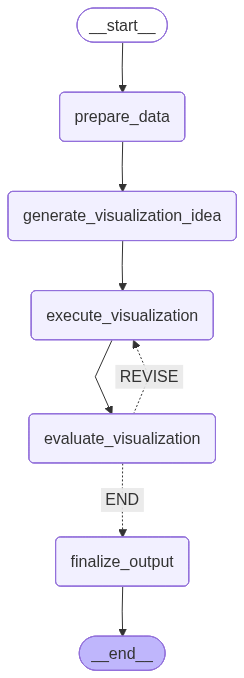

In [54]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node(prepare_data)
builder.add_node(generate_visualization_idea)
builder.add_node(execute_visualization)
builder.add_node(evaluate_visualization)
builder.add_node(finalize_output)

builder.add_edge(START, 'prepare_data')
builder.add_edge('prepare_data','generate_visualization_idea')
builder.add_edge('generate_visualization_idea','execute_visualization')
builder.add_edge('execute_visualization', 'evaluate_visualization')
builder.add_conditional_edges('evaluate_visualization',
                              get_next,
                              {'REVISE':'execute_visualization',
                               'END':'finalize_output'})
graph = builder.compile()

graph

In [55]:
import pprint

initial_state = {
    'file_path':'sample_data.csv',
    'query':'이 파일의 제품별 판매량을 비교해줘.',
    'evaluation':''
}

for data in graph.stream(initial_state, stream_mode='updates'):
    pprint.pprint(data)
    print('----')



{'prepare_data': {'first_analysis': ''}}
----
{'generate_visualization_idea': {'planner_request': '## 시각화 계획서\n'
                                                    '\n'
                                                    '### 1. 데이터 분석\n'
                                                    '\n'
                                                    '*   **데이터 구조 (가정):** 사용자 '
                                                    '쿼리("제품별 판매량을 비교해줘")를 '
                                                    '바탕으로, 데이터 파일은 테이블 형태(예: '
                                                    'CSV, Excel)로 구성되어 있을 것으로 '
                                                    '가정합니다. 최소한 다음 두 가지 핵심 변수를 '
                                                    '포함할 것입니다.\n'
                                                    '    *   `제품명` (Product '
                                                    'Name): 각 판매 기록이 어떤 제품에 '
                                                    '해당하는지 나타내는 범주형 변수.\n'
          

/tmp/ipython-input-3011251929.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(llm, [python_repl_tool],


{'finalize_output': {'final_insight': ['`sample_data.csv` 파일이 생성되었습니다.\n'
                                       '    제품명  판매량\n'
                                       '0   노트북  120\n'
                                       '1  스마트폰  250\n'
                                       '2   태블릿   80\n'
                                       '3   노트북  150\n'
                                       '4   모니터  180'],
                     'img': []}}
----


해당 기능은 하나의 질문에 대해 시각화를 수행합니다.   
전체 그래프를 하나의 서브노드로 만들고, 질문이 주어지면 이를 여러 개의 파생 질문으로 분리하도록 만들어 보겠습니다.

In [17]:
from langgraph.graph import StateGraph, START, END

# SubState 형태로 구성 : Prepare Data는 빼기
class State(TypedDict):
    query : str
    first_analysis : list
    planner_request : str
    file_path : str
    code : str
    evaluation : str
    decision : str
    final_insight : list[str]
    img : list[str]

builder = StateGraph(State)
builder.add_node(generate_visualization_idea)
builder.add_node(execute_visualization)
builder.add_node(evaluate_visualization)
builder.add_node(finalize_output)

builder.add_edge(START, 'generate_visualization_idea')
builder.add_edge('generate_visualization_idea','execute_visualization')
builder.add_edge('execute_visualization', 'evaluate_visualization')
builder.add_conditional_edges('evaluate_visualization',
                              get_next,
                              {'REVISE':'execute_visualization',
                               'END':'finalize_output'})

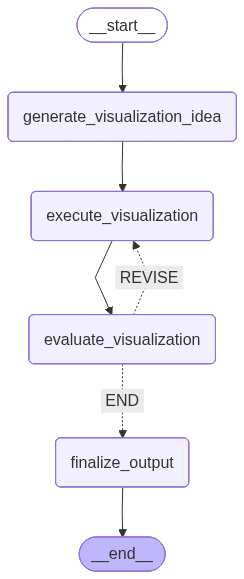

In [18]:
subgraph = builder.compile()
subgraph

In [19]:
from langgraph.types import Send
from typing import Annotated
import operator


class BState(TypedDict):
    question: str
    final_insight: Annotated[list, operator.add]
    img: Annotated[list, operator.add]
    file_path: Annotated[list, operator.add]
    first_analysis: Annotated[list, operator.add]
    queries: list[str]
    num_revision: int


generate_queries_prompt=ChatPromptTemplate(["""
당신은 데이터 분석 전문가입니다.
사용자의 질문에 대한 해답을 얻기 위해,
해당 질문을 보다 자세하고 서로 겹치지 않는 최대 3개의 파생 질문으로 분리하세요.

하나의 시각화로 해결할 수 있는 지표들은 하나의 질문으로 묶어도 좋습니다.

## 데이터 정보:
{first_analysis}

## 사용자 쿼리:
{question}

"""])

class queries(BaseModel):
    queries: list[str] = Field(description="파생 질문 목록")



def generate_queries(state:BState):
    chain = generate_queries_prompt | llm.with_structured_output(queries)
    response = chain.invoke(state).queries
    return {'queries':response}


def assign_workers(state: BState):
    # queries 개수만큼 호출하기
    return [Send("answer_indiv_question", {"query": s, 'evaluation':'',  'file_path':state['file_path'], 'first_analysis':state['first_analysis']}) for s in state["queries"]]

Prepare Data는 모든 작업에서 동시에 진행하므로 큰 라이브러리로 옮겨 줍니다.

In [20]:
# Chart Agent 프롬프트
data_prepare_agent = create_react_agent(llm, [python_repl_tool],
    prompt="""python_repl을 사용해, 주어진 파일을 간단히 분석하세요.

다음의 순서로 실행하세요.
1. 해당 파일을 읽고, 컬럼 이름을 파악하세요.
2. 파악한 결과를 바탕으로, 개략적인 통계 자료를 출력하세요.
주로 다음과 같은 항목이 포함됩니다:
행과 열의 개수
예시 데이터

실패하는 경우, 적절한 인코딩 방식을 활용하여 재시도하세요."""
)



def prepare_data(state:BState):
    messages=[HumanMessage(f"파일 경로는 {state['file_path']} 입니다.")]
    file_path = state['file_path']
    code_result = data_prepare_agent.invoke({'messages':messages})
    first_analysis = code_result['messages'][-1].content
    return {'first_analysis':[first_analysis]}

/tmp/ipython-input-2354750057.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  data_prepare_agent = create_react_agent(llm, [python_repl_tool],


In [21]:
builder2 = StateGraph(BState)
builder2.add_node(prepare_data)
builder2.add_node('answer_indiv_question', subgraph)
builder2.add_node(generate_queries)

builder2.add_edge(START, 'prepare_data')
builder2.add_edge('prepare_data','generate_queries')
builder2.add_conditional_edges("generate_queries", assign_workers, ["answer_indiv_question"])

서브그래프가 포함된 구조는 아래와 같이 xray 설정으로 표시합니다.

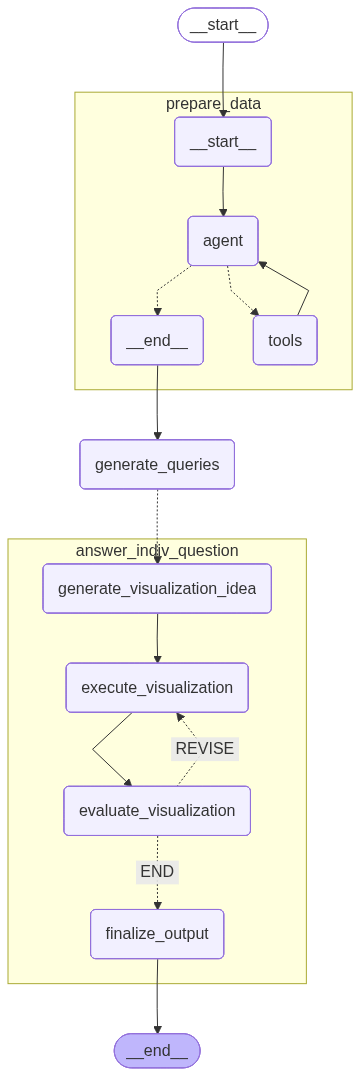

In [22]:
big_graph = builder2.compile()

from IPython.display import Image, display
display(Image(big_graph.get_graph(xray=1).draw_mermaid_png()))

{'prepare_data': {'first_analysis': ['파일 분석 결과:\n'
                                     '\n'
                                     '*   **행 수:** 25\n'
                                     '*   **열 수:** 7\n'
                                     "*   **컬럼 이름:** \\['날짜', '제품', '가격', "
                                     "'판매량', '고객\\_연령', '고객\\_성별', '지역']\n"
                                     '*   **샘플 데이터:** `head()` 함수를 통해 출력된 데이터 '
                                     '참조\n'
                                     '*   **통계:** 가격, 판매량, 고객 연령에 대한 기본 통계 '
                                     '(평균, 표준편차, 최소값, 사분위수, 최대값) 제공']}}
----
{'generate_queries': {'queries': ['제품별 총 판매량은 얼마인가?',
                                  '각 제품의 판매량 분포는 어떻게 다른가?',
                                  '판매량이 가장 높은 제품과 가장 낮은 제품의 판매량 차이는 얼마인가?']}}
----


/tmp/ipython-input-3011251929.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(llm, [python_repl_tool],
<string>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



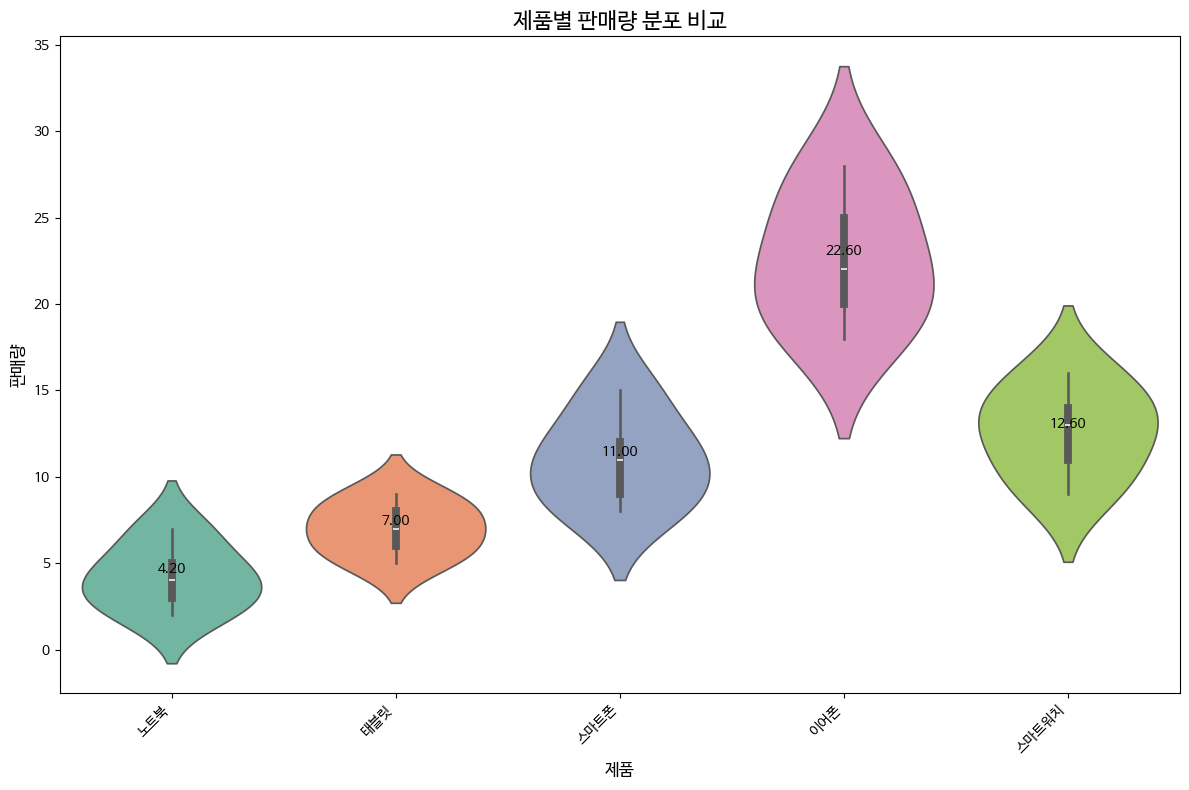

/tmp/ipython-input-3011251929.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(llm, [python_repl_tool],


{'answer_indiv_question': {'file_path': ['sample_data.csv'],
                           'final_insight': ['## 제품별 판매량 분포 보고서\n'
                                             '\n'
                                             '### 분석 개요\n'
                                             '\n'
                                             '본 보고서는 각 제품별 판매량 분포를 비교 분석하여, '
                                             '제품별 판매량의 특징과 차이점을 파악하고, 이를 바탕으로 '
                                             '판매 전략 수립에 필요한 시사점을 도출하는 것을 목표로 '
                                             '합니다.\n'
                                             '\n'
                                             '### 분석 결과\n'
                                             '\n'
                                             '**1. 제품별 판매량 분포 시각화**\n'
                                             '\n'
                                             '[제품별_판매량_분포.png] 이미지에서 각 제품별 판매량 '
                                             '분포를 확인할 수 있습니다.

/tmp/ipython-input-3011251929.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(llm, [python_repl_tool],


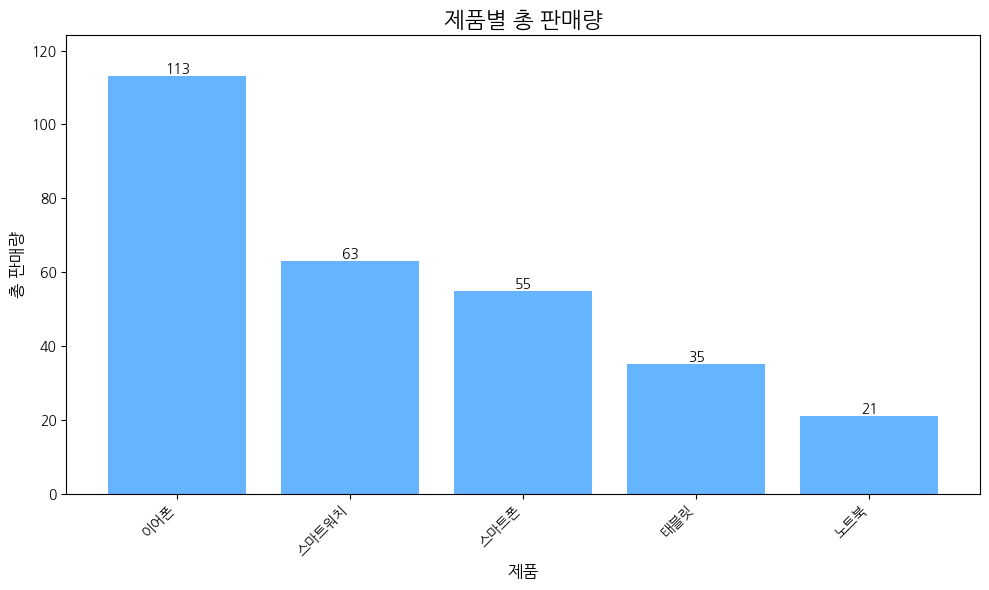

{'answer_indiv_question': {'file_path': ['sample_data.csv'],
                           'final_insight': ['## 제품별 총 판매량 보고서\n'
                                             '\n'
                                             '본 보고서는 제품별 총 판매량을 분석한 결과를 '
                                             '제시합니다.\n'
                                             '\n'
                                             '**1. 시각화 자료:**\n'
                                             '\n'
                                             '[제품별 총 판매량 시각화 이미지 '
                                             '(product_sales_visualization.png) '
                                             '삽입]\n'
                                             '\n'
                                             '**2. 주요 결과:**\n'
                                             '\n'
                                             '위 시각화 자료는 제품별 총 판매량을 막대 그래프로 '
                                             '나타냅니다. 각 제품의 판매량은 다음과 같습니다.\n'
          

In [23]:
initial_state = {
    'file_path':['sample_data.csv'],
    'question':'이 파일의 제품별 판매량을 비교해줘.',
}

for data in big_graph.stream(initial_state, stream_mode='updates'):
    pprint.pprint(data)
    print('----')

/tmp/ipython-input-3011251929.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(llm, [python_repl_tool],


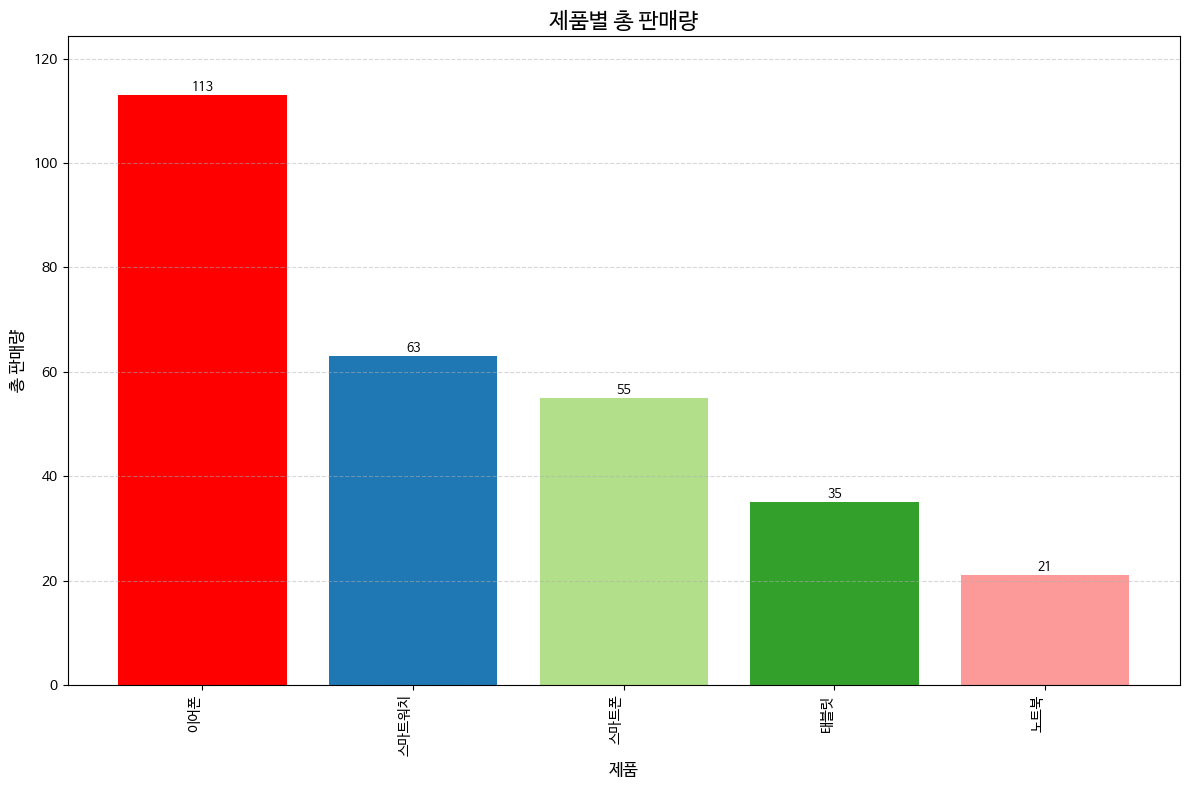

<string>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



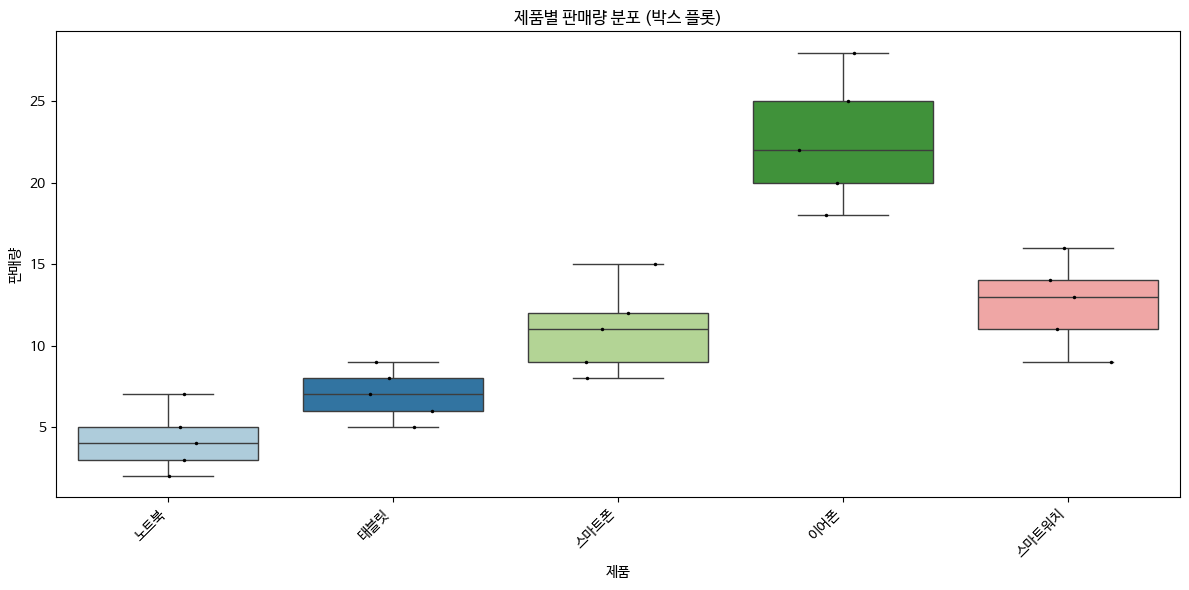

<string>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



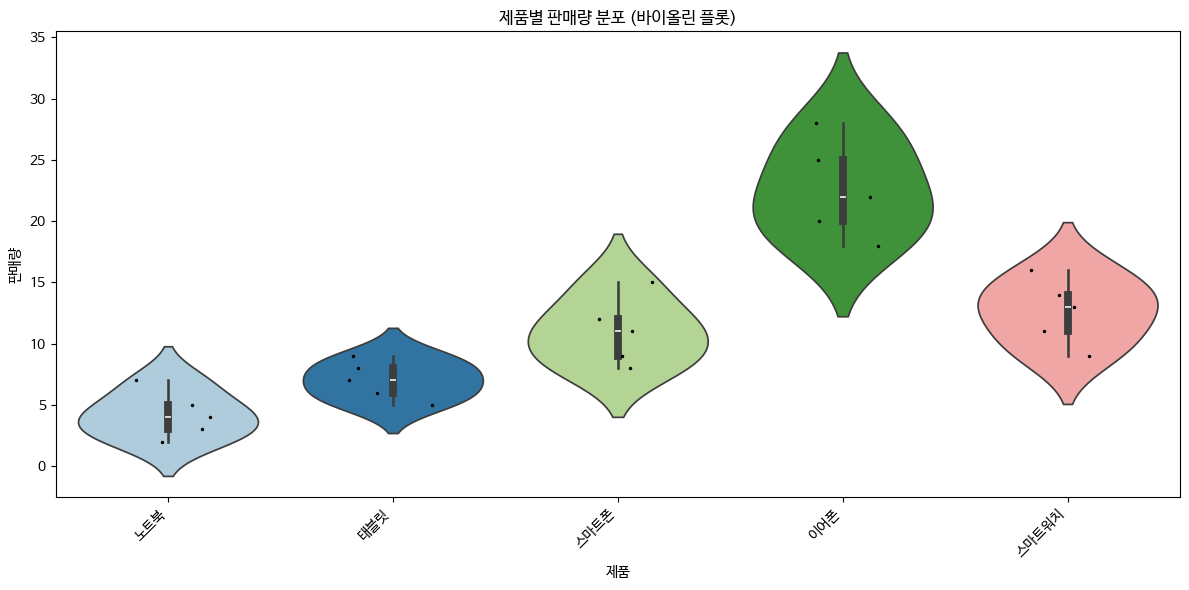

/tmp/ipython-input-3011251929.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  code_agent = create_react_agent(llm, [python_repl_tool],


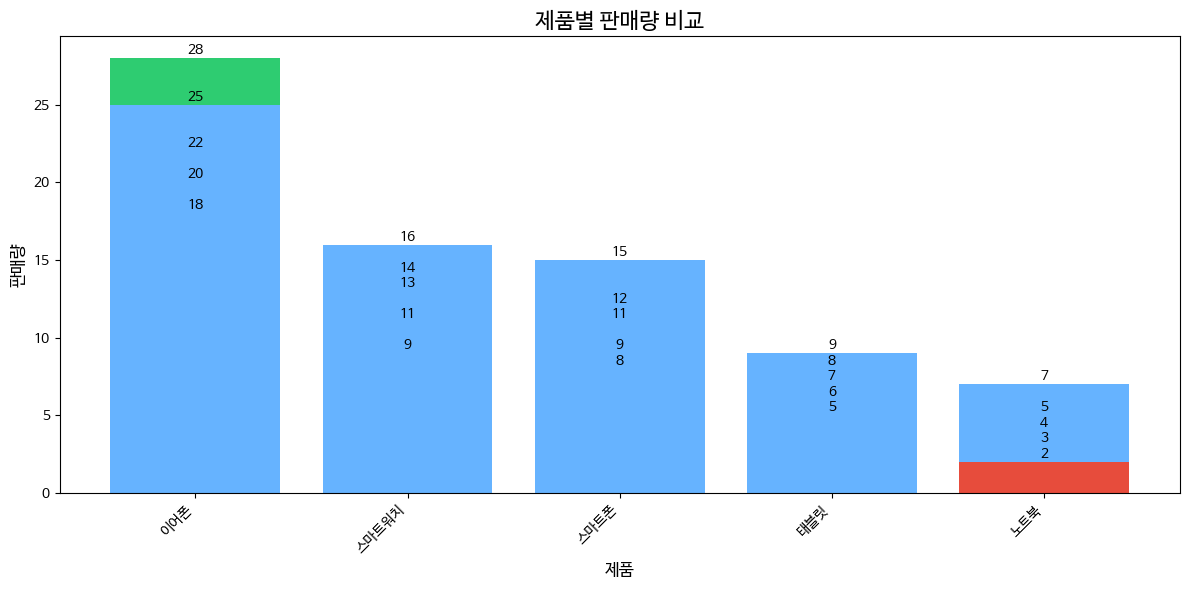

In [24]:
result = big_graph.invoke(initial_state)

In [25]:
result['final_insight']

["## 제품별 총 판매량 보고서\n\n본 보고서는 제품별 총 판매량을 분석한 결과를 제시합니다.\n\n**1. 분석 결과**\n\n아래 막대 그래프는 각 제품별 총 판매량을 시각적으로 보여줍니다.\n\n*   **이미지:** content='{file_path:product_sales_barchart_revised.png}' additional_kwargs={}\n\n**2. 주요 인사이트**\n\n*   **이어폰:** 113개로 가장 높은 판매량을 기록했습니다.\n*   **스마트워치:** 63개로 두 번째로 높은 판매량을 보였습니다.\n*   **스마트폰:** 55개의 판매량을 기록했습니다.\n*   **태블릿:** 35개의 판매량을 나타냈습니다.\n*   **노트북:** 21개로 가장 낮은 판매량을 기록했습니다.\n\n**3. 결론**\n\n이어폰이 압도적으로 높은 판매량을 보이며, 스마트워치가 그 뒤를 잇고 있습니다. 노트북은 다른 제품에 비해 판매량이 저조한 것으로 나타났습니다. 이러한 분석 결과를 바탕으로 제품 전략 및 마케팅 전략을 수립하는 데 활용할 수 있습니다.",
 '## 제품별 판매량 분포 보고서\n\n**질문:** 각 제품의 판매량 분포는 어떠한가?\n\n**분석 결과:**\n\n제품별 판매량 분포를 파악하기 위해 박스 플롯과 바이올린 플롯을 활용하여 시각적으로 분석했습니다.\n\n*   **박스 플롯:** 각 제품의 판매량 중앙값, 사분위수 범위, 이상치 등을 한눈에 파악할 수 있습니다.\n*   **바이올린 플롯:** 각 제품의 판매량 분포 형태를 더욱 자세하게 보여주며, 데이터의 밀도와 분포의 비대칭성을 확인할 수 있습니다.\n\n**시각화 자료:**\n\n*   [제품별 판매량 분포 (박스 플롯)](product_sales_boxplot.png)\n*   [제품별 판매량 분포 (바이올린 플롯)](product_sales_violinplot.png)\n\n**주요 관찰 내용:**\n\n*   **아이폰:** 다른 제품에 비해 판매

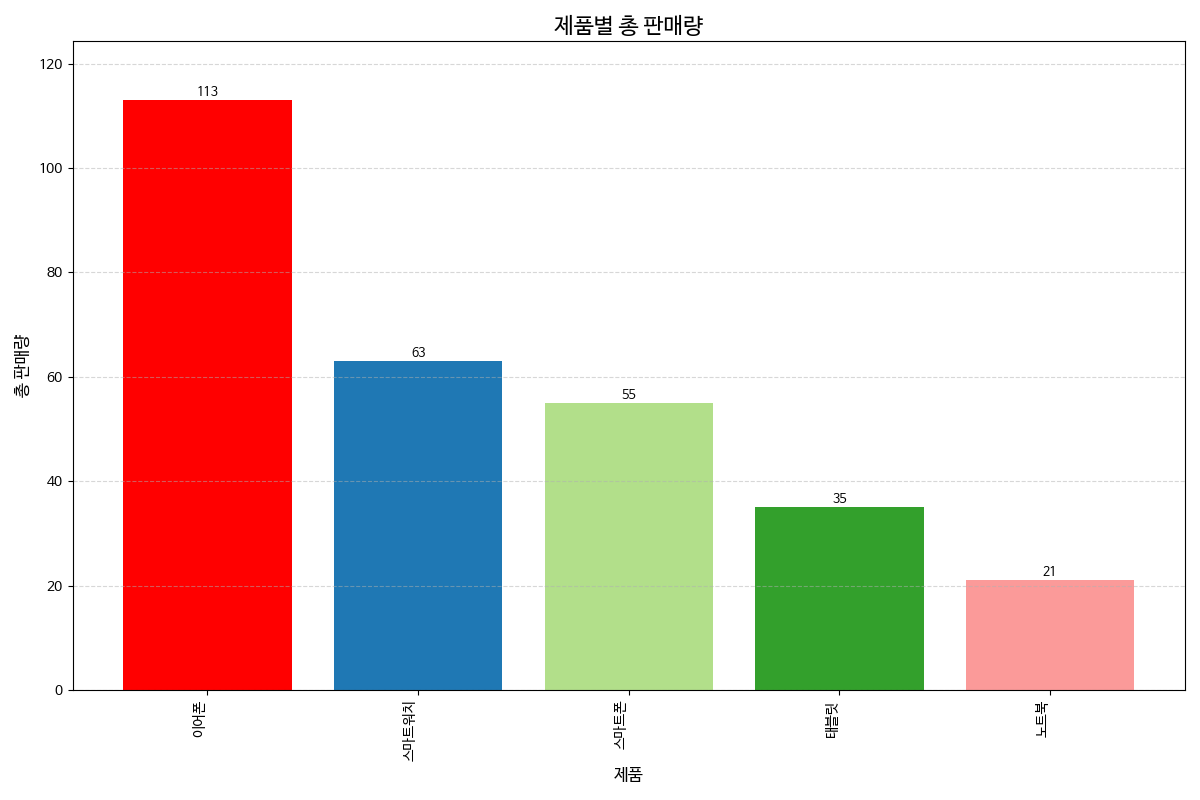

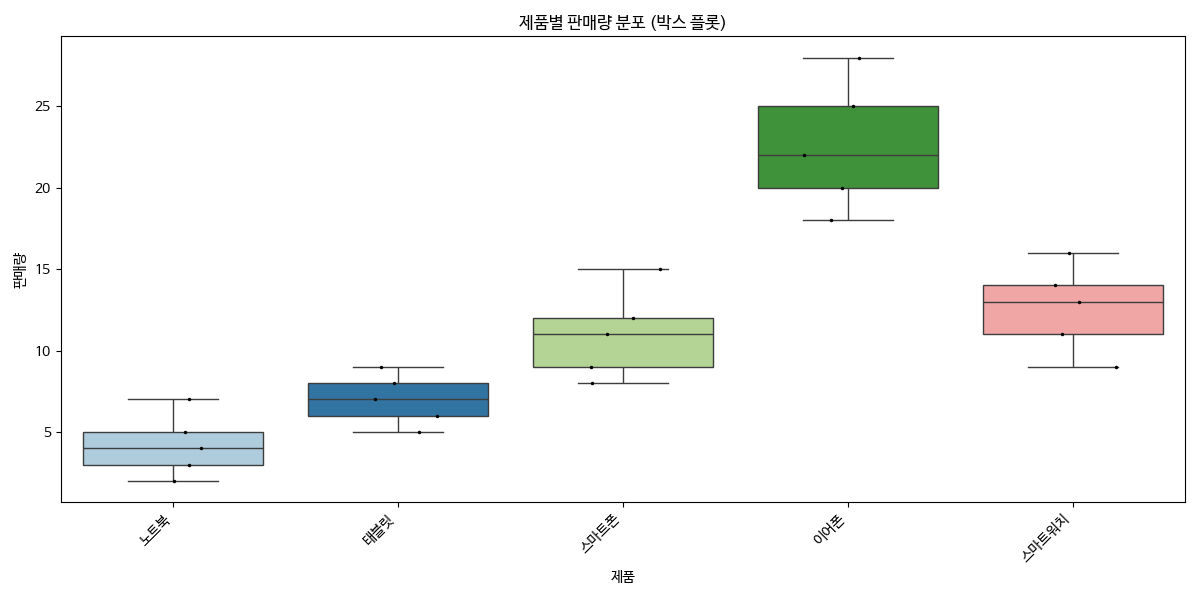

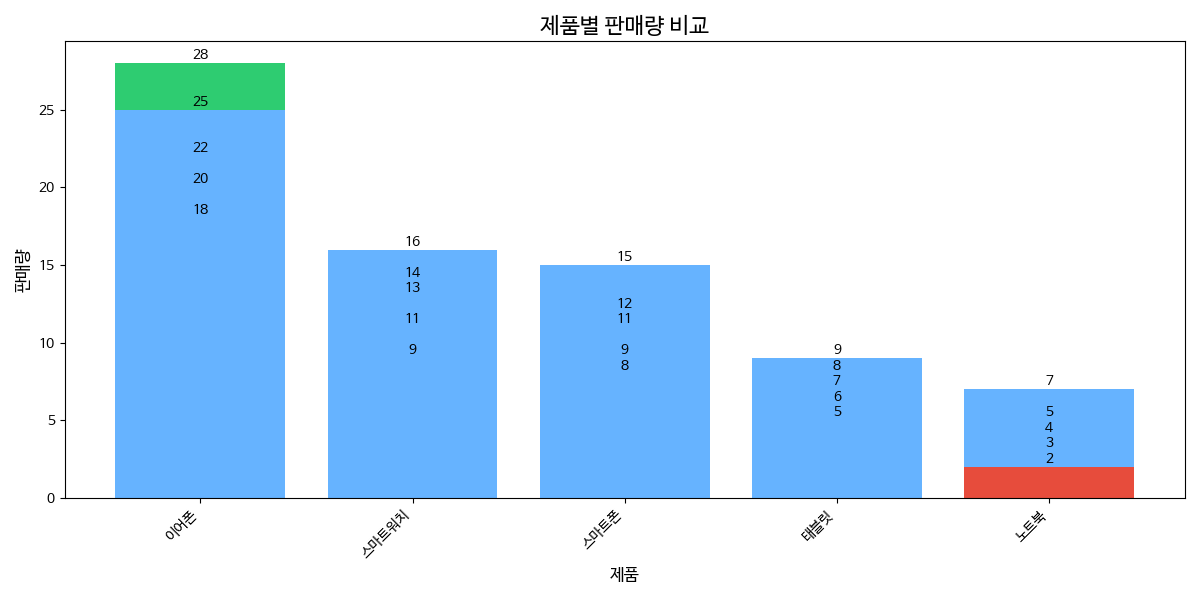

In [26]:
for img in result['img']:
    import base64
    from io import BytesIO

    if isinstance(img, str):
        # If the image is a base64 string, decode and display
        image_data = base64.b64decode(img)
        image = PIL.Image.open(BytesIO(image_data))
        display(image)
    else:
        display(img)